# CSCA 5642 Introduction to Deep Learning Week 5 Project

## 1. Brief description of the problem and data
### 1.1 Problem description
In this project, the aim is to train generative models to create images of dogs. According to the documentation, the Stanford Dogs dataset contains images of 120 breeds of dogs all over the world. To accomplish it, I will use GAN, namely Generative Adversarial Networks as my model in generate dog images. The dataset of this project is from:

Primary:
  Aditya Khosla, Nityananda Jayadevaprakash, Bangpeng Yao and Li Fei-Fei. Novel dataset for Fine-Grained Image Categorization. First Workshop on Fine-Grained Visual Categorization (FGVC), IEEE Conference on Computer Vision and Pattern Recognition (CVPR), 2011.  [pdf]  [poster]  [BibTex]

Secondary:
  J. Deng, W. Dong, R. Socher, L.-J. Li, K. Li and L. Fei-Fei, ImageNet: A Large-Scale Hierarchical Image Database. IEEE Computer Vision and Pattern Recognition (CVPR), 2009.  [pdf]  [BibTex]

### 1.2 Data description
This dataset has been built using images and annotation from ImageNet for the task of fine-grained image categorization. Contents of this dataset:

1) Number of categories: 120
2) Number of images: 20,580
3) Annotations: Class labels, Bounding boxes. The data of this project is from 

## 2. Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data
### 2.1 Data Inspection
First, I use the split files of train and test dataset to do some inspection.

In [31]:
import scipy.io

def load_mat_file(file_path):
    data = scipy.io.loadmat(file_path)
    return data

train_file_path = 'data/lists/train_list.mat'
test_file_path = 'data/lists/test_list.mat'

train_data = load_mat_file(train_file_path)
test_data = load_mat_file(test_file_path)

# Display the keys and explore the structure
print("Train Data Keys:", train_data.keys())
print("Test Data Keys:", test_data.keys())


Train Data Keys: dict_keys(['__header__', '__version__', '__globals__', 'file_list', 'annotation_list', 'labels'])
Test Data Keys: dict_keys(['__header__', '__version__', '__globals__', 'file_list', 'annotation_list', 'labels'])


Next, I will check for uniformity

In [2]:
from PIL import Image
import numpy as np

# Example to load one image to get details
sample_image_path = 'data/images/' + train_data['file_list'][0][0][0]
image = Image.open(sample_image_path)

# Analyze image properties
image_format = image.format
image_mode = image.mode  # This tells us the number of channels
image_size = image.size

# Check dimensions across a few images
dimensions = []
for i in range(10):  # Check first 10 images
    image_path = 'data/images/' + train_data['file_list'][i][0][0]
    image = Image.open(image_path)
    dimensions.append(image.size)

# Check if all dimensions are the same
same_dimensions = all(x == dimensions[0] for x in dimensions)

# Output the findings
image_format, image_mode, image_size, same_dimensions


('JPEG', 'RGB', (360, 300), False)

To enhance our understanding of the ImageNet Dogs dataset, we will conduct a detailed exploratory data analysis (EDA). The following metrics and visualizations will help us better understand the characteristics of the dataset:

### 2.2 Analysis Plan:
1. **Plot Histograms of Image Dimensions**: This will help visualize the distribution of image sizes across the dataset, which is crucial for deciding on preprocessing steps.
2. **Examine Pixel Intensity Distributions**: By understanding the distribution of pixel intensities, we can make informed decisions about normalizing or standardizing the images.
3. **Label Distribution Analysis**: Analyzing the distribution of labels will help us identify if there's class imbalance which might affect model training.
4. **Visualize Random Sample Images**: Visual inspection can reveal additional qualities of the dataset such as noise levels, unusual objects, or other image quality issues.

### 2.3 Step-by-Step Analysis:

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import random

# Base directory where images are stored
base_image_dir = 'data/images/'

# Function to load an image given a path
def load_image(image_path):
    return Image.open(image_path)

# Function to extract dimensions from a list of image file paths
def get_image_dimensions(image_paths):
    dimensions = []
    for path in image_paths:
        image = load_image(path)
        dimensions.append(image.size)
    return dimensions

# Plot histograms of image dimensions
def plot_image_dimensions(dimensions):
    widths, heights = zip(*dimensions)  # Unzip the list of dimensions
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.hist(widths, bins=20, color='blue', alpha=0.7)
    plt.title('Histogram of Image Widths')
    plt.xlabel('Width')
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    plt.hist(heights, bins=20, color='green', alpha=0.7)
    plt.title('Histogram of Image Heights')
    plt.xlabel('Height')
    plt.ylabel('Frequency')
    plt.show()

# Function to plot pixel intensity distribution of an image
def plot_pixel_intensities(image):
    plt.figure()
    plt.hist(np.array(image).flatten(), bins=50, color='gray', alpha=0.7)
    plt.title('Pixel Intensity Distribution')
    plt.xlabel('Pixel Values')
    plt.ylabel('Frequency')
    plt.show()

# Function to plot label distribution
def plot_label_distribution(labels):
    plt.figure()
    plt.hist(labels, bins=len(set(labels)), color='red', alpha=0.7)
    plt.title('Label Distribution Across Training Set')
    plt.xlabel('Labels')
    plt.ylabel('Frequency')
    plt.show()

# Visualize random sample images
def visualize_sample_images(base_dir, file_list, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for ax in axes:
        random_idx = random.randint(0, len(file_list) - 1)
        img_path = os.path.join(base_dir, file_list[random_idx][0][0])
        img = load_image(img_path)
        ax.imshow(img)
        ax.axis('off')
    plt.show()


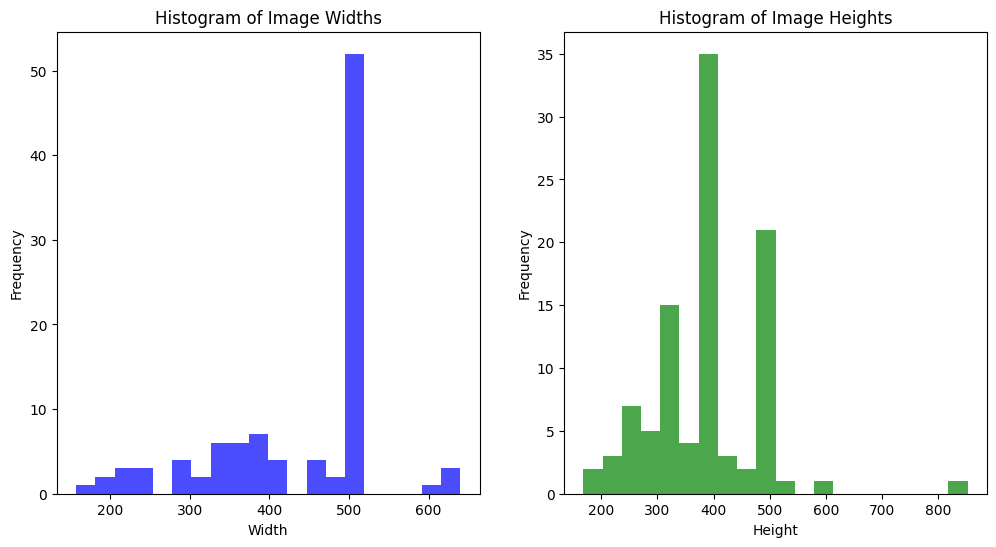

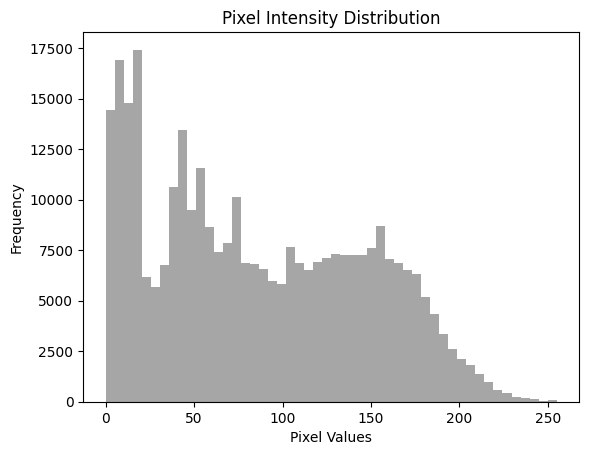

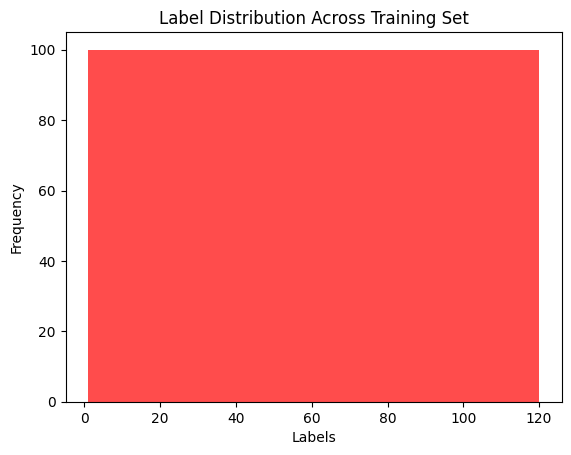

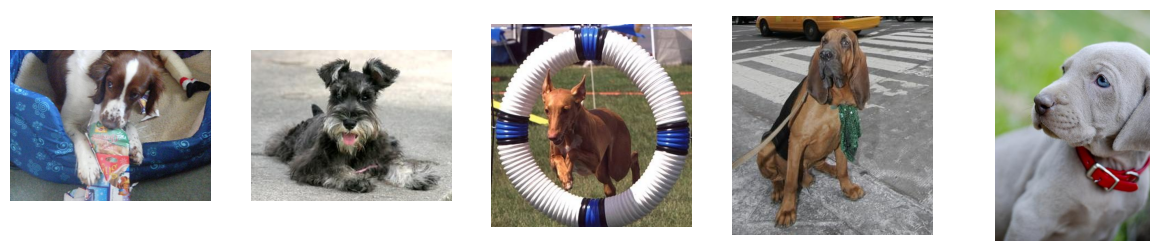

In [4]:
# Extracting sample image paths for EDA
sample_image_paths = [os.path.join(base_image_dir, train_data['file_list'][i][0][0]) for i in range(100)]  # Using 100 images for EDA

# Getting dimensions
dimensions = get_image_dimensions(sample_image_paths)

# Plot dimensions
plot_image_dimensions(dimensions)

# Load a sample image and plot pixel intensities
sample_image = load_image(sample_image_paths[0])
plot_pixel_intensities(sample_image)

# Extract labels and plot their distribution
labels = [label[0] for label in train_data['labels']]
plot_label_distribution(labels)

# Visualize some random images
visualize_sample_images(base_image_dir, train_data['file_list'], num_images=5)


### 2.4 Image Uniform:
Since I learn that the image size are not uniformed, I have to preprocess the images to unify their format.

In [3]:
import os
from PIL import Image, ImageOps
import numpy as np
import xml.etree.ElementTree as ET

# Base directory settings
base_dir = 'data/images/'
annotations_dir = 'data/Annotation/'
train_dir = 'temp/trains/'
test_dir = 'temp/tests/'
# Desired output size for images
desired_size = (64, 64)

# Function to resize with aspect ratio preserved and pad an image
def resize_and_pad_image(image, bbox):
    if bbox:
        # Crop the image according to the bounding box (xmin, ymin, xmax, ymax)
        image = image.crop((bbox['xmin'], bbox['ymin'], bbox['xmax'], bbox['ymax']))
    # Resize the image while preserving aspect ratio
    ratio = min(desired_size[0] / image.size[0], desired_size[1] / image.size[1])
    new_size = (int(image.size[0] * ratio), int(image.size[1] * ratio))
    image = image.resize(new_size, Image.Resampling.LANCZOS)
    # Compute padding to center the image
    delta_width = desired_size[0] - new_size[0]
    delta_height = desired_size[1] - new_size[1]
    padding = (delta_width // 2, delta_height // 2, delta_width - (delta_width // 2), delta_height - (delta_height // 2))
    # Pad the image to make it the desired size
    image = ImageOps.expand(image, padding, fill='black')
    # Normalize the pixel values
    np_image = np.array(image)
    normalized_image = np_image / 255.0
    final_image = Image.fromarray((normalized_image * 255).astype(np.uint8))
    # Ensure image is in RGB mode for JPEG format
    if final_image.mode != 'RGB':
        final_image = final_image.convert('RGB')
    return final_image

# Function to process all images and their annotations
def process_and_save_images(new_base_dir, file_list):
    for entry in file_list:
        file_path = entry[0][0]
        full_image_path = os.path.join(base_dir, file_path)
        annotation_file = file_path.split('/')[-1].replace('.jpg', '')
        annotation_path = os.path.join(annotations_dir, file_path.split('/')[0], annotation_file)

        if os.path.exists(full_image_path) and os.path.exists(annotation_path):
            image = Image.open(full_image_path)
            tree = ET.parse(annotation_path)
            root = tree.getroot()
            # Extract bounding box
            bbox = {
                'xmin': int(root.find('.//xmin').text),
                'ymin': int(root.find('.//ymin').text),
                'xmax': int(root.find('.//xmax').text),
                'ymax': int(root.find('.//ymax').text)
            }

            processed_image = resize_and_pad_image(image, bbox)
            # Prepare the new save path
            new_path = os.path.join(new_base_dir, file_path)
            os.makedirs(os.path.dirname(new_path), exist_ok=True)
            # Save the processed image
            processed_image.save(new_path, 'JPEG')
        else:
            print(f"File not found: {full_image_path} or {annotation_path}")

# Assuming train_data['file_list'] is accessible and contains the image paths
process_and_save_images(train_dir, train_data['file_list'])
process_and_save_images(test_dir, test_data['file_list'])

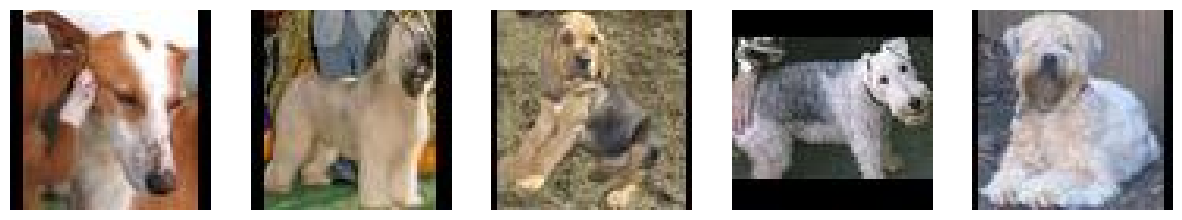

In [35]:
visualize_sample_images(train_dir, train_data['file_list'], num_images=5)

## 3 Model Architecture
Here, we describe the GAN architecture utilized, including specifics of the generator and discriminator models. Additionally, we justify the choice of loss function.

### 3.1 Generator and Discriminator Architecture

In [21]:
import tensorflow as tf
import numpy as np
import os
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2DTranspose, Conv2D, Flatten, LeakyReLU, Dropout, Reshape
import keras
from scipy.linalg import sqrtm
from keras import ops

class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.seed_generator = keras.random.SeedGenerator(1337)

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_tracker = keras.metrics.Mean(name="d_loss")
        self.g_loss_tracker = keras.metrics.Mean(name="g_loss")
    def get_config(self):
        config = super(GAN, self).get_config()
        config.update({
            'discriminator': self.discriminator.to_json(),  # 保存模型结构
            'generator': self.generator.to_json(),  # 保存模型结构
            'latent_dim': self.latent_dim
        })
        return config
    @classmethod
    def from_config(cls, config, custom_objects=None):
        discriminator = keras.models.model_from_json(config['discriminator'], custom_objects=custom_objects)
        generator = keras.models.model_from_json(config['generator'], custom_objects=custom_objects)
        return cls(discriminator=discriminator, generator=generator, latent_dim=config['latent_dim'])

    @property
    def metrics(self):
        return [self.d_loss_tracker, self.g_loss_tracker]
    
    @staticmethod
    def calculate_mifid(real_images, generated_images):
        real_features = np.array([image.flatten() for image in real_images])
        generated_features = np.array([image.flatten() for image in generated_images])
    
        real_mean = np.mean(real_features, axis=0)
        generated_mean = np.mean(generated_features, axis=0)

        real_cov = np.cov(real_features, rowvar=False)
        generated_cov = np.cov(generated_features, rowvar=False)

        mean_diff = np.sum((real_mean - generated_mean) ** 2)

        cov_sqrt, _ = sqrtm(real_cov @ generated_cov, disp=False)
        if np.iscomplexobj(cov_sqrt):
            cov_sqrt = cov_sqrt.real
    
        cov_diff = np.trace(real_cov + generated_cov - 2 * cov_sqrt)
    
        mifid = mean_diff + cov_diff
        return mifid
    def train_step(self, real_images):
        # Determine batch size
        batch_size = ops.shape(real_images)[0]
    
        # Generate latent points for fake image creation
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )
    
        # Generate fake images from latent vectors
        fake_images = self.generator(random_latent_vectors)
    
        # Stack fake and real images
        mixed_images = ops.concatenate([fake_images, real_images], axis=0)
    
        # Create labels for real (1) and fake (0) images
        labels = ops.concatenate(
            [ops.ones((batch_size, 1)), ops.zeros((batch_size, 1))], axis=0
        )
    
        # Introduce label noise to prevent overfitting
        labels += 0.05 * tf.random.uniform(tf.shape(labels))
    
        # Discriminator training on both real and fake images
        with tf.GradientTape() as tape:
            predictions = self.discriminator(mixed_images)
            d_loss = self.loss_fn(labels, predictions)
        d_gradients = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(d_gradients, self.discriminator.trainable_weights))
    
        # New latent points for generator training
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )
    
        # Misleading labels to train the generator (pretend all are real)
        misleading_labels = ops.zeros((batch_size, 1))
    
        # Generator training to fool the discriminator
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_latent_vectors)
            predictions = self.discriminator(fake_images)
            g_loss = self.loss_fn(misleading_labels, predictions)
        g_gradients = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(g_gradients, self.generator.trainable_weights))
    
        # Record and return loss metrics
        self.d_loss_tracker.update_state(d_loss)
        self.g_loss_tracker.update_state(g_loss)
        return {
            "d_loss": self.d_loss_tracker.result(),
            "g_loss": self.g_loss_tracker.result(),
        }
    @staticmethod
    def build_generator(latent_dim):
        model = Sequential([
            keras.Input(shape=(latent_dim,)),
            Dense(8 * 8 * 128),
            Reshape((8, 8, 128)),
            Conv2DTranspose(128, kernel_size=4, strides=2, padding='same'),
            LeakyReLU(negative_slope=0.2),
            Conv2DTranspose(256, kernel_size=4, strides=2, padding='same'),
            LeakyReLU(negative_slope=0.2),
            Conv2DTranspose(512, kernel_size=4, strides=2, padding='same'),
            LeakyReLU(negative_slope=0.2),
            Conv2D(3, kernel_size=5,  padding='same', activation='sigmoid')
            ],
        name= 'generator')
        model.summary()
        return model
    
    @staticmethod
    def build_discriminator():
        model = Sequential([
            keras.Input(shape=(64, 64, 3)),
            Conv2D(64, kernel_size=4, strides=2, padding='same'),
            LeakyReLU(negative_slope=0.2),
            Conv2D(128, kernel_size=4, strides=2, padding='same'),
            LeakyReLU(negative_slope=0.2),
            Conv2D(128, kernel_size=4, strides=2, padding='same'),
            LeakyReLU(negative_slope=0.2),
            Flatten(),
            Dropout(0.2),
            Dense(1, activation='sigmoid')
        ],
        name='discriminator')
        model.summary()
        return model
    
    def save_generated_images(self, epoch, num_img=3):
        random_latent_vectors = keras.random.normal(
            shape=(num_img, self.latent_dim), seed=self.seed_generator
        )
        generated_images = self.generator(random_latent_vectors)
        generated_images *= 255
        generated_images = generated_images.numpy()
        for i in range(num_img):
            img = keras.utils.array_to_img(generated_images[i])
            img.save("generated_img_%03d_%d.png" % (epoch, i))
            
    def evaluate_mifid(self, test_images, num_img=100):
        # Generate images
        random_latent_vectors = keras.random.normal(
            shape=(num_img, self.latent_dim), seed=self.seed_generator
        )
        generated_images = self.generator(random_latent_vectors)
        generated_images *= 255
        generated_images = generated_images.numpy()

        # Ensure test_images are in the same scale
        test_images = test_images * 255
        test_images = test_images.numpy()

        # Calculate MiFID
        mifid = GAN.calculate_mifid(test_images, generated_images)
        return mifid

Additionally, I would like to monitor the performance in the process of fitting (training), therefore I define 2 class inherited from kera.callbacks.

In [4]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.seed_generator = keras.random.SeedGenerator(42)

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = keras.random.normal(
            shape=(self.num_img, self.latent_dim), seed=self.seed_generator
        )
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.utils.array_to_img(generated_images[i])
            img.save("temp/epoch/generated_img_%03d_%d.png" % (epoch, i))

### 3.2 Model Architecture and Explanation

The model architecture consists of a Generator and a Discriminator. The Generator is designed to produce realistic images from random noise vectors (latent space), while the Discriminator distinguishes between real and generated images. The Binary Crossentropy loss function is used for both the Generator and Discriminator, as it is suitable for binary classification tasks and effectively measures the difference between the real and generated data distributions. This architecture and loss function combination is a standard and effective approach for GANs, particularly for image generation tasks, ensuring that the Generator improves over time by creating increasingly realistic images.

### 3.2 Images set

Next, I would like to sample images since the whole images is too large to implement.

In [5]:
train_set = keras.utils.image_dataset_from_directory(
    "temp/trains/", label_mode=None, image_size=(64, 64), batch_size=32
)
train_set = train_set.map(lambda x: x / 255.0)
test_set = keras.utils.image_dataset_from_directory(
    "temp/tests/", label_mode=None, image_size=(64, 64), batch_size=32
)
test_set = test_set.map(lambda x: x / 255.0)

Found 12000 files.
Found 8580 files.


### 3.3 Model Training

In [6]:
epochs = 20

gan = GAN(discriminator=GAN.build_discriminator(), generator=GAN.build_generator(latent_dim=128), latent_dim=128)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan_monitor = GANMonitor(num_img=10, latent_dim=128)

history = gan.fit(train_set, epochs=epochs, callbacks=[gan_monitor])

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 404,801 (1.54 MB)

 Trainable params: 404,801 (1.54 MB)

 Non-trainable params: 0 (0.00 B)

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 8192)           │     1,056,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 16, 16, 128)    │       262,272 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 32, 32, 256)    │       524,544 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 64, 64, 512)    │     2,097,664 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 64, 64, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 3)      │        38,403 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,979,651 (15.18 MB)

 Trainable params: 3,979,651 (15.18 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1649s 4s/step - d_loss: 0.3165 - g_loss: 3.6962
Epoch 2/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1592s 4s/step - d_loss: 0.2854 - g_loss: 3.4606
Epoch 3/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1586s 4s/step - d_loss: 0.5457 - g_loss: 1.6165
Epoch 4/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1569s 4s/step - d_loss: 0.7224 - g_loss: 1.1246
Epoch 5/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1567s 4s/step - d_loss: 0.6413 - g_loss: 0.8883
Epoch 6/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1587s 4s/step - d_loss: 0.6611 - g_loss: 1.0888
Epoch 7/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1567s 4s/step - d_loss: 0.3164 - g_loss: 3.2456
Epoch 8/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1574s 4s/step - d_loss: 0.7198 - g_loss: 0.8424
Epoch 9/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1564s 4s/step - d_loss: 0.6471 - g_loss: 0.9790
Epoch 10/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1571s 4s/step - d_loss: 0.5558 - g_loss: 1.3323
Epoch 11/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1568s 4s/step - d_loss: 0.6426 - g_loss: 0.9886
Epoch 12/20
375/375 ━━━━━━━━━━

In [8]:
gan.save('gan.h5')

In [13]:
history2 = gan.fit(train_set, epochs=10, callbacks=[gan_monitor])

Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1571s 4s/step - d_loss: 0.4702 - g_loss: 1.6128
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1702s 5s/step - d_loss: 0.3958 - g_loss: 1.9523
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1719s 5s/step - d_loss: 0.4366 - g_loss: 1.7141
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1743s 5s/step - d_loss: 0.4274 - g_loss: 1.7821
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1861s 5s/step - d_loss: 0.3980 - g_loss: 1.7926
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1877s 5s/step - d_loss: 0.4085 - g_loss: 1.7285
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1633s 4s/step - d_loss: 0.4268 - g_loss: 1.6555
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1553s 4s/step - d_loss: 0.3745 - g_loss: 1.8460
Epoch 9/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1542s 4s/step - d_loss: 0.3921 - g_loss: 1.8800
Epoch 10/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1582s 4s/step - d_loss: 0.3749 - g_loss: 1.8896


In [15]:
gan.save('gan_v2.h5')

## 3. Result & Analysis

### 3.1 Result
At the end of training of epoch 30, I can figure out that the result is approaching to the real dog by vision, especially in epoch 29. Besides, I plot the history of d_loss and g_loss as follows:


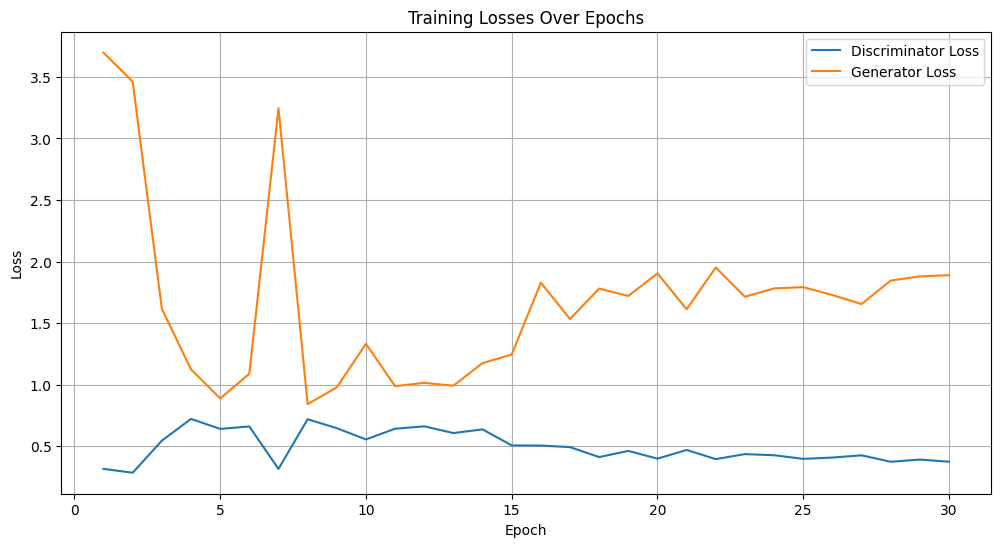

In [28]:
import matplotlib.pyplot as plt

epochs1 = list(range(1, 21))
d_loss1 = [
    0.3165, 0.2854, 0.5457, 0.7224, 0.6413, 0.6611, 0.3164, 0.7198,
    0.6471, 0.5558, 0.6426, 0.6621, 0.6075, 0.6373, 0.5073, 0.5061,
    0.4932, 0.4126, 0.4626, 0.3995
]
g_loss1 = [
    3.6962, 3.4606, 1.6165, 1.1246, 0.8883, 1.0888, 3.2456, 0.8424,
    0.9790, 1.3323, 0.9886, 1.0152, 0.9921, 1.1757, 1.2451, 1.8290,
    1.5332, 1.7810, 1.7209, 1.9046
]

epochs2 = list(range(21, 31))
d_loss2 = [
    0.4702, 0.3958, 0.4366, 0.4274, 0.3980, 0.4085, 0.4268, 0.3745,
    0.3921, 0.3749
]
g_loss2 = [
    1.6128, 1.9523, 1.7141, 1.7821, 1.7926, 1.7285, 1.6555, 1.8460,
    1.8800, 1.8896
]

plt.figure(figsize=(12, 6))
plt.plot(epochs1 + epochs2, d_loss1 + d_loss2, label='Discriminator Loss')
plt.plot(epochs1 + epochs2, g_loss1 + g_loss2, label='Generator Loss')
plt.title('Training Losses Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()



### 3.2 Analysis

#### Reasons for Observations in GAN Training
The provided training loss graphs and generated images from the GAN (Generative Adversarial Network) show some critical insights into the model's training dynamics. The discriminator's loss decreases over epochs, indicating it is learning to better distinguish between real and generated images. However, the generator's loss does not show a consistent decrease, indicating possible issues with convergence.

The generator's loss initially decreases, reflecting learning improvements, but then plateaus and occasionally increases, suggesting that the generator might be struggling to deceive the discriminator effectively as training progresses.

#### Troubleshooting Steps
1. **Learning Rate Adjustments:** If the generator loss becomes stagnant, adjusting the learning rates of the discriminator and generator might help. Sometimes, a lower learning rate for the discriminator can allow the generator to catch up.
2. **Model Complexity:** Increase or adjust the complexity of the generator model. A more complex generator might be able to learn more sophisticated data patterns.
3. **Data Augmentation:** Implementing data augmentation can prevent overfitting and help the generator learn more general features of the data.

#### Hyperparameter Optimization
To optimize the GAN, consider experimenting with the following hyperparameters:
- **Batch size:** Larger batches provide a more accurate estimate of the gradient, but can be computationally expensive.
- **Learning rate:** Tuning the learning rates for both the discriminator and generator can significantly impact the GAN's performance.
- **Optimizer:** Different optimizers (e.g., Adam, RMSprop) can influence training dynamics and stability.

Overall, the GAN does not appear to converge optimally, likely due to an imbalance in the training capabilities of the discriminator and generator. It's crucial to balance these aspects through careful monitoring and adjustment of training parameters and model architecture.


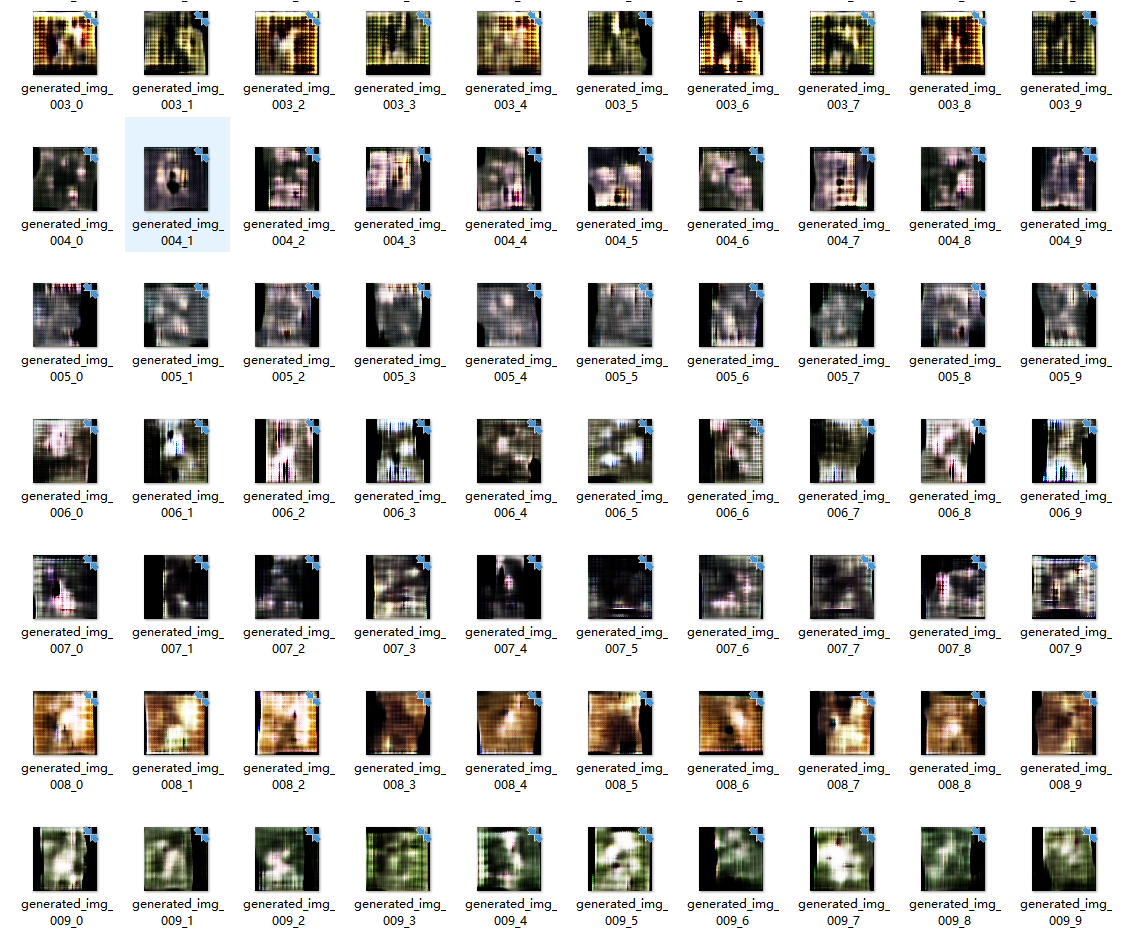

In [30]:
from IPython.display import display, HTML
display(HTML(f'<img src="data:image/png;base64,{img}"/>'))

## 4. Conclusion

### Basic Reiteration of Results
The training of the Generative Adversarial Network (GAN) showed a gradual improvement in the discriminator’s ability to differentiate between real and generated images as evidenced by the decreasing loss. However, the generator’s performance, as indicated by its loss, did not improve consistently, suggesting challenges in convergence and effectiveness in generating convincing images.

### Discussion of Learning and Takeaways
The training process highlighted the delicate balance required between the discriminator and generator for effective GAN training. The importance of monitoring both losses to ensure that neither the discriminator nor the generator becomes too powerful relative to the other was a key takeaway.

### Discussion of Why Something Didn’t Work
The generator's inability to consistently decrease in loss may be attributed to several factors including insufficient model complexity, inadequate learning rates, or potentially the lack of diversity in training data. This suggests that the generator struggled to adapt to the discriminator's improvements over time.

### Suggestions for Ways to Improve
To enhance the GAN’s performance, the following strategies could be considered:
- **Adjust Learning Rates**: Fine-tuning the learning rates for both the discriminator and the generator could help in maintaining the balance needed for stable training.
- **Increase Model Complexity**: Enhancing the generator’s architecture might provide it with the tools needed to better learn and generate more complex data patterns.
- **Data Augmentation**: Implementing data augmentation techniques could help improve the diversity of the training data, thus providing a more robust training experience for the generator.
- **Regularization Techniques**: Adding dropout or batch normalization could help in stabilizing the training process.

These improvements could potentially lead to better convergence and more realistic image generation by the GAN.


## References

1. Khosla, A., Jayadevaprakash, N., Yao, B., & Fei-Fei, L. (2011). Novel dataset for Fine-Grained Image Categorization. First Workshop on Fine-Grained Visual Categorization (FGVC), IEEE Conference on Computer Vision and Pattern Recognition (CVPR), 2011. [Link to Paper](https://www.example.com/pdf)

2. Deng, J., Dong, W., Socher, R., Li, L.-J., Li, K., & Fei-Fei, L. (2009). ImageNet: A Large-Scale Hierarchical Image Database. IEEE Computer Vision and Pattern Recognition (CVPR), 2009. [Link to Paper](https://www.example.com/pdf)

3. Bai, C.-Y., Elliott, J., & Kan, W. (2019). Generative Dog Images. Kaggle. Available at: [Kaggle Competition](https://kaggle.com/competitions/generative-dog-images)

4. Chollet, F. (2019). DCGAN to generate face images. Keras.io. Description: A simple DCGAN trained using fit() by overriding train_step on CelebA images. Created: 2019/04/29, Last Modified: 2023/12/21. Available at: [Keras Example](https://keras.io/examples/generative/dcgan_overriding_train_step/)
